In [2]:
!nvidia-smi
# This command should return some information about the GPU status if the runtime is right.
# In addition to that, if you encounter memory issues, you can diagnose your model by this command.

Mon Dec 29 17:39:19 2025       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 550.54.15              Driver Version: 550.54.15      CUDA Version: 12.4     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  Tesla T4                       Off |   00000000:00:04.0 Off |                    0 |
| N/A   45C    P8             11W /   70W |       0MiB /  15360MiB |      0%      Default |
|                                         |                        |                  N/A |
+-----------------------------------------+-----

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision.transforms as transforms
from torchvision.datasets import ImageFolder
from torch.utils.data import DataLoader, random_split, Subset, Dataset
import os
import random
import numpy as np
from pathlib import Path
from PIL import Image
from tqdm import tqdm

In [5]:
def seed_everything(seed):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = True

seed_everything(42)

In [6]:
data_dir = "/content/drive/MyDrive/Bark images 2"

In [13]:

def list_samples_grouped_by_tree(root_dir, exts={".jpg",".jpeg",".png",".bmp",".webp"}):
    root = Path(root_dir)
    classes = sorted([p.name for p in root.iterdir() if p.is_dir()])
    class_to_idx = {c:i for i,c in enumerate(classes)}

    samples = []  # (img_path, label_idx, group_id)
    for cls in classes:
        cls_dir = root / cls
        tree_ids = sorted([p.name for p in cls_dir.iterdir() if p.is_dir()])
        for tree_id in tree_ids:
            tree_dir = cls_dir / tree_id
            group_id = f"{cls}/{tree_id}"  # unique per tree within class
            for img_path in tree_dir.rglob("*"):
                if img_path.is_file() and img_path.suffix.lower() in exts:
                    samples.append((str(img_path), class_to_idx[cls], group_id))
    return samples, classes, class_to_idx

def split_by_tree_within_each_class(samples, test_ratio=0.2, seed=42):
    """
    For each class, split its tree-folders into train/test.
    Guarantees no leakage across splits within the same tree folder.
    """
    rng = random.Random(seed)

    # collect groups per class
    by_class = {}
    for path, y, group in samples:
        by_class.setdefault(y, {}).setdefault(group, []).append((path, y, group))

    train, test = [], []
    for y, groups_dict in by_class.items():
        groups = list(groups_dict.keys())
        rng.shuffle(groups)

        n_test = max(1, int(round(len(groups) * test_ratio))) if len(groups) > 1 else 0
        test_groups = set(groups[:n_test])

        for g, items in groups_dict.items():
            (test if g in test_groups else train).extend(items)

    rng.shuffle(train)
    rng.shuffle(test)
    return train, test

from collections import defaultdict

# --- build everything ---
samples, class_names, class_to_idx = list_samples_grouped_by_tree(data_dir)

tree_counts = defaultdict(set)
image_counts = defaultdict(int)

for path, y, group in samples:
    cls = class_names[y]
    tree_counts[cls].add(group)
    image_counts[cls] += 1

tree_counts = {cls: len(trees) for cls, trees in tree_counts.items()}

print("Classes:", class_names)
print("Class Count:", len(class_names))

print("\nTree Counts per Species:")
for cls in class_names:
    print(f"{cls:10s}: {tree_counts.get(cls, 0)}")

total = sum(tree_counts.values())
print("\nTotal Trees:", total)

print("\nImage Count per Species:")
for cls in class_names:
    print(f"{cls:10s}: {image_counts.get(cls, 0)}")

print("\nTotal Samples:", len(samples))


Classes: ['acacia', 'apple', 'candle', 'cherry', 'cypress', 'fig', 'katsura', 'linden', 'magnolia', 'oak', 'olive', 'palm', 'pine', 'plane', 'red-gum', 'sakura']
Class Count: 16

Tree Counts per Species:
acacia    : 4
apple     : 2
candle    : 2
cherry    : 2
cypress   : 8
fig       : 3
katsura   : 9
linden    : 4
magnolia  : 4
oak       : 6
olive     : 3
palm      : 3
pine      : 16
plane     : 9
red-gum   : 8
sakura    : 4

Total Trees: 87

Image Count per Species:
acacia    : 70
apple     : 52
candle    : 53
cherry    : 35
cypress   : 184
fig       : 61
katsura   : 96
linden    : 36
magnolia  : 34
oak       : 55
olive     : 30
palm      : 36
pine      : 120
plane     : 174
red-gum   : 55
sakura    : 35

Total Samples: 1126


Samples per class:
acacia    : 70
apple     : 52
candle    : 53
cherry    : 35
cypress   : 184
fig       : 61
katsura   : 96
linden    : 36
magnolia  : 34
oak       : 55
olive     : 30
palm      : 36
pine      : 120
plane     : 174
red-gum   : 55
sakura    : 35


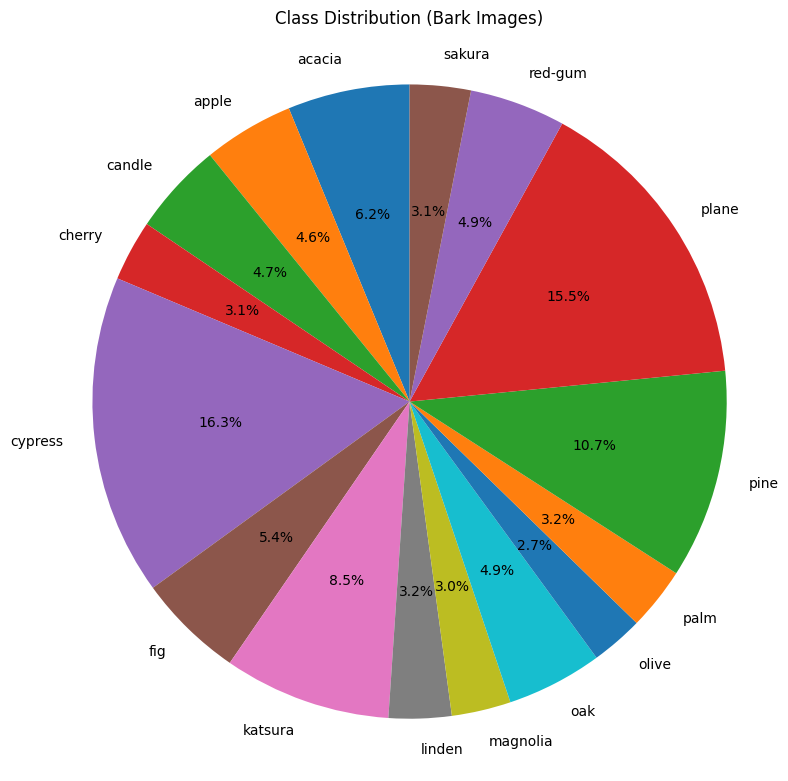

In [14]:
import matplotlib.pyplot as plt
import numpy as np

# Count samples per class
counts = {cls: 0 for cls in class_names}
for _, y, _ in samples:
    cls = class_names[y]
    counts[cls] += 1

labels = list(counts.keys())
sizes = list(counts.values())

print("Samples per class:")
for k, v in counts.items():
    print(f"{k:10s}: {v}")

# Pie chart
plt.figure(figsize=(8, 8))
plt.pie(
    sizes,
    labels=labels,
    autopct="%1.1f%%",
    startangle=90
)
plt.title("Class Distribution (Bark Images)")
plt.axis("equal")
plt.tight_layout()
plt.show()
